In [11]:
import numpy as np
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
from discretisedfield.tools import hopf_index

In [15]:
r = 100e-9  # Nanodisk radius
t = 70e-9  # Nanodisk thickness
d = 10e-9  # Thickness of thin disks at ends

region = df.Region(p1=(-r, -r, -d), p2=(r, r, t+d))
subregions = {'bottom': df.Region(p1=(-r, -r, -d), p2=(r, r, 0)),
              'cylinder': df.Region(p1=(-r, -r, 0), p2=(r, r, t)),
              'top': df.Region(p1=(-r, -r, t), p2=(r, r, t+d))}
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), subregions=subregions)

In [16]:
system = mm.System(name='hopfion')

system.energy = (mm.Exchange(A=2.195e-12)
               + mm.DMI(D=3.95e-4, crystalclass='T'))

In [17]:
Ms = 3.84e5

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 100nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < r:
        return Ms
    else:
        return 0

In [21]:
L = t/2
R = t/4
w = t/8

def m_init(pos):
    
    x, y, z = pos
    z -= t/2

    psi = np.arctan2(y, x)

    xPrime = (x - L*np.cos(psi)) * np.cos(psi) + (y - L*np.sin(psi)) * np.sin(psi)
    yPrime = y - L*np.sin(psi)

    rho = np.sqrt(xPrime**2 + z**2)
    Phi = np.arctan2(z, xPrime)
    Theta = 2 * np.arctan2(np.sinh(R/w), np.sinh(rho/w))

    myPrime = np.cos(Phi) * np.sin(Theta)
    mz = np.cos(Theta)
    mxPrime = np.sin(Phi) * np.sin(Theta)

    mx = mxPrime*np.cos(psi) - myPrime*np.sin(psi)
    my = mxPrime*np.sin(psi) + myPrime*np.cos(psi)
    
    return (mx, my, mz)

m = {'bottom': (0, 0, 1), 'cylinder': m_init, 'top': (0, 0, 1)}
system.m = df.Field(mesh, nvdim=3, value=m, norm=Ms_fun)

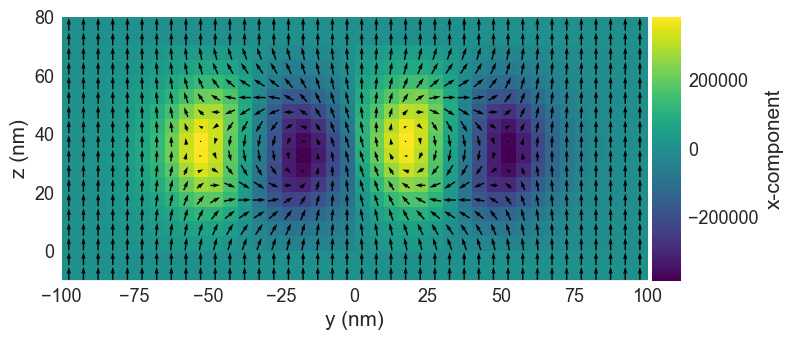

In [23]:
system.m.sel('x').mpl()

In [24]:
print(hopf_index(system.m))

0.856705280041214
0.9953767631268698


In [10]:
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=0.2)

md = oc.MinDriver()
md.drive(system, fixed_subregions=['bottom', 'top'])

system.m.write('FromMinDriver.ovf')

Running OOMMF (ExeOOMMFRunner)[2023/05/01 14:31]... (28.6 s)


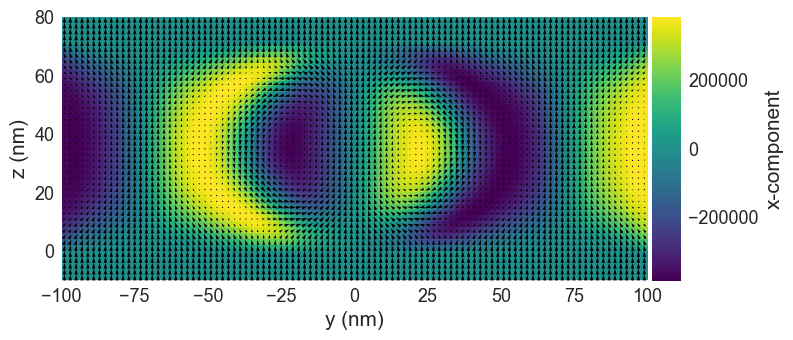

In [11]:
system.m.plane('x').mpl()

In [12]:
print(hopf_index(relaxed))

1.0277543778178884
1.0526270162572802
